In [2]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib as plt
import glob

# Normalize the Geojsons and Shapefiles
We have many different municipalities with different zoning codes to normalize into one shared system.  
A lot of this has already been done by Smirthi using the filter.py and read.py files in the scripts folder.

In [22]:
south_fulton_gdf = gpd.read_file('../data/geo/SouthFulton_Zoning/CurrentZoning.shp')

In [32]:
south_fulton_gdf['ZClass'].unique()

array(['CUP', 'SUB-C', 'C-2', 'R-4A', 'AG-1', 'R-3', 'R-2', 'C-1', 'R-4',
       'O-I', 'SUB-A', 'R-6', 'M-1A', 'M-1', 'MIX', 'TR', 'A-L', 'NUP',
       'R-5A', 'R-3A', 'A', 'R-5', 'M-2', 'R-2A', 'A-1', 'UNKNOWN', 'SH',
       'Water', 'CHC-MIX', None], dtype=object)

In [40]:
single_family = ['SUB-C', 'R-4A', 'R-3', 'R-2', 'R-4', 'SUB-A', 'R-5A', 'R-3A', 'R-5']
multi_family = ['CUP', 'R-6', 'TR', 'A-L', 'NUP', 'A', 'A-1', 'SH']
mixed_use = ['MIX', 'CHC-MIX']
commercial = ['C-2', 'C-1', 'O-I']

In [41]:
south_fulton_gdf = south_fulton_gdf[['ZClass', 'geometry']]

In [42]:
def normalize_labels(x):
    if x in single_family:
        return 'Single Family Residential'
    elif x in multi_family:
        return 'Multiple Family Residential'
    elif x in commercial:
        return 'Commercial'
    elif x in mixed_use:
        return 'Mixed Use'
    else:
        return 'Unknown'

In [43]:
south_fulton_gdf['zoning_description'] = south_fulton_gdf['ZClass'].apply(lambda x: normalize_labels(x))

In [59]:
south_fulton_gdf = south_fulton_gdf.to_crs(4326)

In [64]:
# Calculate centroids for each geometry and add them as new columns
south_fulton_gdf['centroid_lat'] = south_fulton_gdf['geometry'].apply(lambda x: x.centroid.y)
south_fulton_gdf['centroid_lon'] = south_fulton_gdf['geometry'].apply(lambda x: x.centroid.x)

In [65]:
south_fulton_gdf = south_fulton_gdf[['ZClass', 'zoning_description', 'centroid_lat', 'centroid_lon', 'geometry']].rename(columns={'ZClass': 'zoning_classification'})

In [67]:
south_fulton_gdf.to_file('../data/geo/filtered/southfulton_filtered.geojson')

In [114]:
# Get a list of all geojson files in the directory
files = glob.glob('../data/geo/filtered/*.geojson')

files_gpd = []

for file in files:
    with open(file, 'r') as f:
        data = gpd.read_file(file)
        files_gpd.append(data)

In [115]:
for i, file in enumerate(files_gpd):
    files_gpd[i] = file.to_crs(4326)

In [125]:
atlanta_gdf = gpd.pd.concat(files_gpd, axis=0, ignore_index=True)

In [126]:
atlanta_gdf

,zoning_classification,zoning_description,centroid_lat,centroid_lon,geometry
0,MR-1,Multiple Family Residential,33.707238,-84.155460,"POLYGON ((-84.15542 33.70721, -84.15542 33.707..."
1,RSM,Single Family Residential,33.633899,-84.117816,"POLYGON ((-84.11754 33.63391, -84.11755 33.633..."
2,RSM,Single Family Residential,33.635890,-84.116669,"POLYGON ((-84.11647 33.63640, -84.11635 33.636..."
3,RSM,Single Family Residential,33.635797,-84.116359,"POLYGON ((-84.11603 33.63629, -84.11603 33.636..."
4,RSM,Single Family Residential,33.635705,-84.116049,"POLYGON ((-84.11580 33.63623, -84.11571 33.636..."
...,...,...,...,...,...
337200,M,Mixed Use,33.828266,-84.345180,"POLYGON ((-84.34570 33.82852, -84.34480 33.827..."
337201,ANX,Unknown,33.832505,-84.323015,"POLYGON ((-84.32342 33.83260, -84.32317 33.832..."
337202,ANX,Unknown,33.832078,-84.322854,"POLYGON ((-84.32316 33.83220, -84.32290 33.831..."
337203,RS-85,Unknown,33.832822,-84.323107,"POLYGON ((-84.32362 33.83295, -84.32360 33.832..."


In [127]:
atlanta_gdf[atlanta_gdf['geometry'] == None]

,zoning_classification,zoning_description,centroid_lat,centroid_lon,geometry


In [128]:
atlanta_gdf['zoning_description'].unique()

array(['Multiple Family Residential', 'Single Family Residential',
       'Mixed Use', 'Commercial', 'Unknown'], dtype=object)

<Axes: >

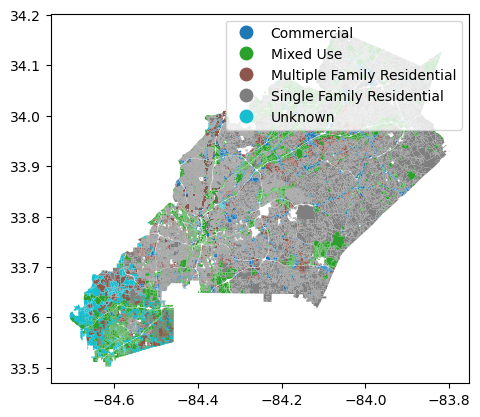

In [129]:
atlanta_gdf.plot(column='zoning_description', legend=True)

In [130]:
# Designate Five Points Station, Decatur Station, Sandy Springs Station, Doraville Station, and One Buckhead Plaza as CBDs against which the distances will be compared.
five_points = (33.75398679797445, -84.3915512609736) #0
decatur = (33.774690110641785, -84.29533383094311) #1
sandy_springs = (33.93243624793804, -84.35190195697518) #2
doraville = (33.902784451480215, -84.28021523126014) #3
buckhead_plaza = (33.839509187072366, -84.3816621167917) #4

cbds = [five_points, decatur, sandy_springs, doraville, buckhead_plaza]

In [144]:
from geopy.distance import geodesic
import numpy as np
from tqdm import tqdm

for k in range(4):
    range_start = k * round(atlanta_gdf.shape[0] / 4)
    range_end = ((k + 1) * round(atlanta_gdf.shape[0] / 4)) if k != 3 else atlanta_gdf.shape[0]
    atlanta_part = atlanta_gdf.iloc[range_start:range_end, :].copy()
    atlanta_part = atlanta_part.reset_index(drop=True)

    for i in tqdm(range(atlanta_part.shape[0])):
        distances = [geodesic((atlanta_part.iloc[i]['centroid_lat'], atlanta_part.iloc[i]['centroid_lon']), cbd).miles for cbd in cbds]
        closest_index = np.argmin(distances)
        atlanta_part.loc[i, 'distance_cbd'] = distances[closest_index]
        atlanta_part.loc[i, 'cbd_index'] = closest_index

    atlanta_part.to_file(f'../data/geo/part{k}.geojson')

100%|██████████| 84302/84302 [01:07<00:00, 1255.25it/s]


In [145]:
atlanta_gpd_parts = []
for k in range(4):
    atlanta_gpd_parts.append(gpd.read_file(f'../data/geo/part{k}.geojson'))

In [146]:
housing_gdf = gpd.pd.concat(atlanta_gpd_parts, ignore_index=True)

In [147]:
housing_gdf

,zoning_classification,zoning_description,centroid_lat,centroid_lon,distance_cbd,cbd_index,geometry
0,MR-1,Multiple Family Residential,33.707238,-84.155460,9.299244,1.0,"POLYGON ((-84.15542 33.70721, -84.15542 33.707..."
1,RSM,Single Family Residential,33.633899,-84.117816,14.096814,1.0,"POLYGON ((-84.11754 33.63391, -84.11755 33.633..."
2,RSM,Single Family Residential,33.635890,-84.116669,14.050957,1.0,"POLYGON ((-84.11647 33.63640, -84.11635 33.636..."
3,RSM,Single Family Residential,33.635797,-84.116359,14.068362,1.0,"POLYGON ((-84.11603 33.63629, -84.11603 33.636..."
4,RSM,Single Family Residential,33.635705,-84.116049,14.085773,1.0,"POLYGON ((-84.11580 33.63623, -84.11571 33.636..."
...,...,...,...,...,...,...,...
337200,M,Mixed Use,33.828266,-84.345180,2.236864,4.0,"POLYGON ((-84.34570 33.82852, -84.34480 33.827..."
337201,ANX,Unknown,33.832505,-84.323015,3.407500,4.0,"POLYGON ((-84.32342 33.83260, -84.32317 33.832..."
337202,ANX,Unknown,33.832078,-84.322854,3.420964,4.0,"POLYGON ((-84.32316 33.83220, -84.32290 33.831..."
337203,RS-85,Unknown,33.832822,-84.323107,3.399209,4.0,"POLYGON ((-84.32362 33.83295, -84.32360 33.832..."


<Axes: >

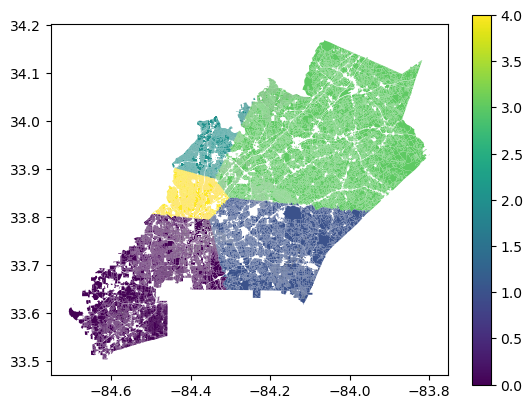

In [ ]:
housing_gdf[housing_gdf['zoning_description'].apply(lambda x: x not in ['Commercial', 'Unknown'])].plot(column='cbd_index', legend=True)

In [186]:
housing_gdf = gpd.read_file("../data/geo/filtered/all_filtered.geojson")

SJ: 7246
-Commercial: 1150 (15.8%)
-MF: 679 (9.3%)
-SF: 5417 (74.7%)

- MF: 11.14%
- SF: 88.86%

Seattle: 3203
-Commercial: 1515 (47.3%)
-MF: 1252 (39%)
-SF: 436 (13.6%)

- MF: 74.17%
- SF: 25.83%

Austin: 14789
-Commercial: 2221 (15%)
-MF: 1983 (13.4%)
-SF: 10585 (71.57%)

- MF: 15.78%
- SF: 84.22%

Atlanta: 139469
-Commercial: 23466 (16.8%) 65968
-MF: 22189 (15.9%) 54392
-SF: 93814 (67.3%) 18967


In [187]:
# Adjust the mixes to reflect other cities distributions
atlanta_housing_only = housing_gdf[housing_gdf['zoning_description'].apply(lambda x: x not in ['Commercial', 'Unknown', 'Mixed Use'])]
atlanta_non_housing = housing_gdf[housing_gdf['zoning_description'].apply(lambda x: x in ['Commercial', 'Unknown', 'Mixed Use'])]

In [169]:
# Atlanta housing percentages for the municipalities we have available.
atlanta_housing_only['zoning_description'].value_counts()

zoning_description
Single Family Residential      189829
Multiple Family Residential     43388
Name: count, dtype: int64

In [191]:
def upsample_zoning(housing_gdf, target_percentages, current_mix):
    total_sum = np.sum([v for k, v in current_mix.items()])
    distances = housing_gdf['distance_cbd'].astype('float64')

    desired_counts = {}
    for i, (k, v) in enumerate(target_percentages.items()):
        if i == len(target_percentages.items()) - 1:
            desired_counts[k] = total_sum - np.sum([v for k,v in desired_counts.items()])
        else:
            desired_counts[k] = round(total_sum * v)

    discrepancy_count = {k: current_mix[k] - desired_counts[k] for k in desired_counts.keys()}

    # I can probably come back here and make sampling probabilities which increase with distance for downscaling
    # and decrease vice versa
    # Or maybe just make two columns one for up sample and one for downsampling

    for_sampling_gdf = None
    sampling_weights = None
    if discrepancy_count['Single Family Residential'] < 0: # We're downsampling
        for_sampling_gdf = housing_gdf[housing_gdf['zoning_description'].apply(lambda x: x != 'Single Family Residential')]
        sampling_weights = for_sampling_gdf['distance_cbd']
        sampling_weights /= sampling_weights.sum()

        samples = np.random.choice(for_sampling_gdf.index, size=-discrepancy_count['Single Family Residential'], replace=False, p=sampling_weights)
        housing_gdf.loc[samples, 'zoning_description'] = 'Single Family Residential'
    elif discrepancy_count['Multiple Family Residential'] < 0: # We're upsampling
        for_sampling_gdf = housing_gdf[housing_gdf['zoning_description'].apply(lambda x: x != 'Multiple Family Residential')]
        sampling_weights = for_sampling_gdf['distance_cbd']
        sampling_weights = 1 / sampling_weights
        sampling_weights /= sampling_weights.sum()
        samples = np.random.choice(for_sampling_gdf.index, size=-discrepancy_count['Multiple Family Residential'], replace=False, p=sampling_weights)
        housing_gdf.loc[samples, 'zoning_description'] = 'Multiple Family Residential'
    else: # Do nothing
        return housing_gdf

# Example usage:
target_percentages = {
    'Single Family Residential': 0.95,
    'Multiple Family Residential': 0.05,
}

current_mix = {
    'Single Family Residential': 189829,
    'Multiple Family Residential': 43388
}

upzone_df = atlanta_housing_only.copy()
upsampled_atlanta = upsample_zoning(upzone_df, target_percentages, current_mix)


<Axes: >

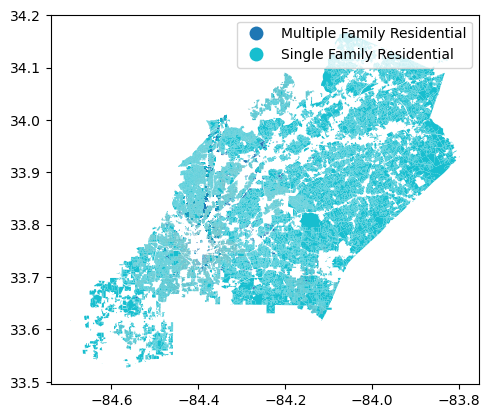

In [192]:
upzone_df.plot(column='zoning_description', legend=True)

<Axes: >

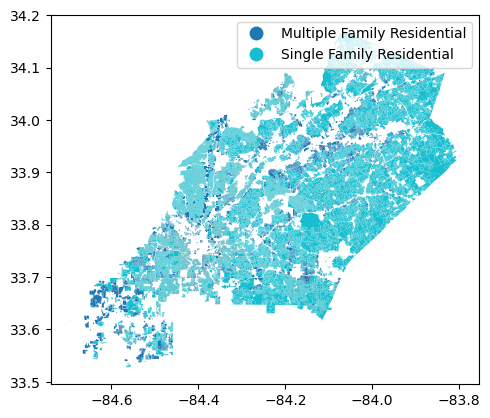

In [190]:
atlanta_housing_only.plot(column='zoning_description', legend=True)

Now let's actually resample to Seattle densities, etc.

In [195]:
# Example usage:
sj_percentages = {
    'Single Family Residential': 0.8886,
    'Multiple Family Residential': 0.1114,
}

seattle_percentages = {
    'Single Family Residential': 0.2583,
    'Multiple Family Residential': 0.7417,
}

austin_percentages = {
    'Single Family Residential': 0.8422,
    'Multiple Family Residential': 0.1578,
}

current_mix = {
    'Single Family Residential': 189829,
    'Multiple Family Residential': 43388
}

sj_atlanta = atlanta_housing_only.copy()
upsample_zoning(sj_atlanta, sj_percentages, current_mix)

seattle_atlanta = atlanta_housing_only.copy()
upsample_zoning(seattle_atlanta, seattle_percentages, current_mix)

austin_atlanta = atlanta_housing_only.copy()
upsample_zoning(austin_atlanta, austin_percentages, current_mix)


<Axes: >

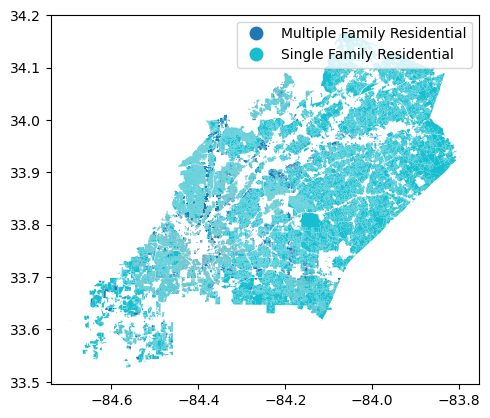

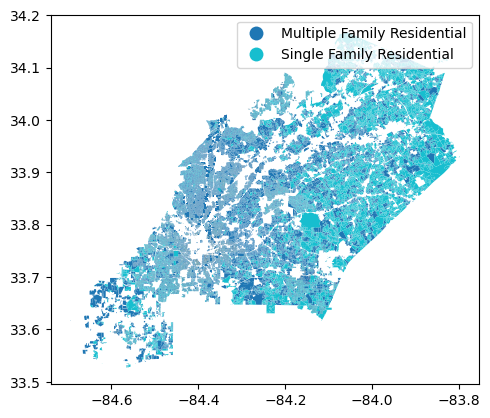

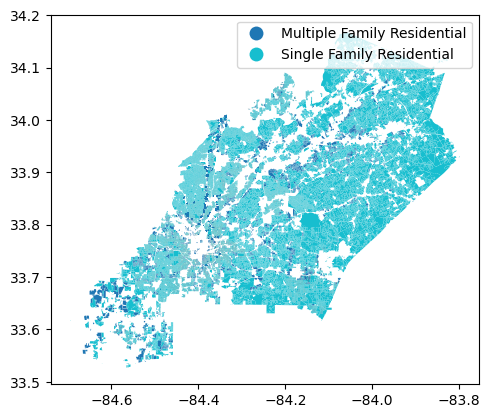

In [196]:
sj_atlanta.plot(column='zoning_description', legend=True)
seattle_atlanta.plot(column='zoning_description', legend=True)
austin_atlanta.plot(column='zoning_description', legend=True)

In [197]:
seattle_final = gpd.pd.concat([atlanta_non_housing, seattle_atlanta], ignore_index=True)
sj_final = gpd.pd.concat([atlanta_non_housing, sj_atlanta], ignore_index=True)
austin_final = gpd.pd.concat([atlanta_non_housing, austin_atlanta], ignore_index=True)

<Axes: >

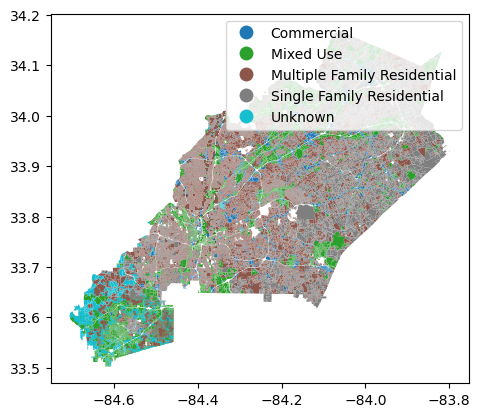

In [198]:
seattle_final.plot(column='zoning_description', legend=True)

In [202]:
seattle_final[['zoning_description', 'geometry']].to_file('../data/geo/final/seattle_atlanta.geojson')
sj_final[['zoning_description', 'geometry']].to_file('../data/geo/final/sj_atlanta.geojson')
austin_final[['zoning_description', 'geometry']].to_file('../data/geo/final/austin_atlanta.geojson')

In [204]:
housing_gdf[['zoning_description', 'geometry']].to_file('../data/geo/final/atlanta.geojson')